# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:**__Kritika Chopra__________

*Semester:* Fall 2024

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

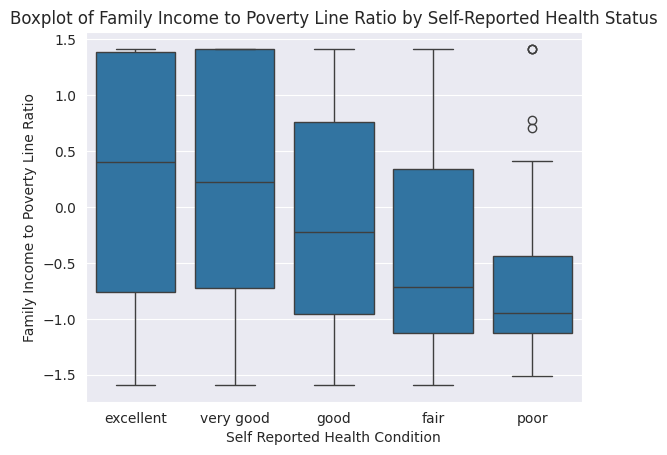

In [3]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor'])
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

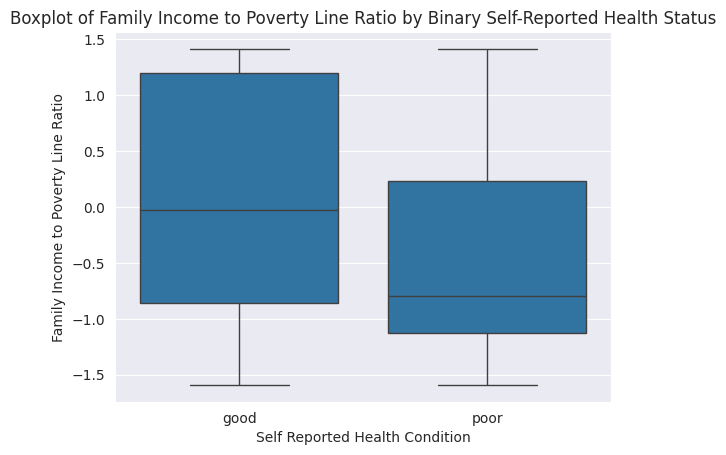

In [4]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy.

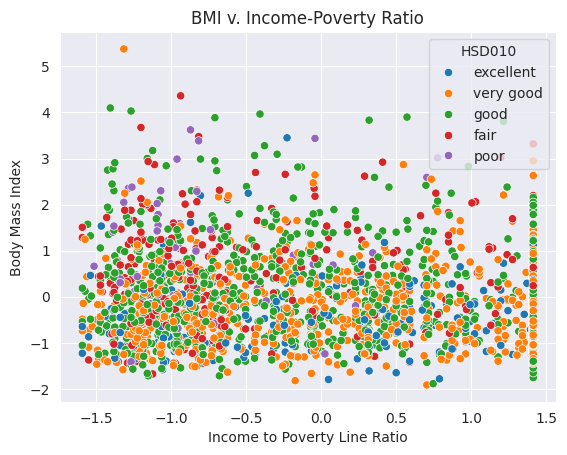

In [5]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [6]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components.
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model.
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

In [3]:
import pandas as pd
from sklearn.decomposition import PCA

# Step 1: Perform PCA
pca_nhanes = PCA()
nhanes_pca_result = pca_nhanes.fit_transform(nhanes_scaled)

# Step 2: Calculate explained variance
nhanes_explained_variance = pd.DataFrame({
    "Principal Component": [f"PC{i+1}" for i in range(len(pca_nhanes.explained_variance_ratio_))],
    "Explained Variance Ratio": pca_nhanes.explained_variance_ratio_,
    "Cumulative Variance Ratio": pca_nhanes.explained_variance_ratio_.cumsum()
})

# Display the total number of PCs
total_pcs = len(pca_nhanes.explained_variance_ratio_)
print(f"Total number of PCs: {total_pcs}")

# Step 3: Determine the number of components explaining 80% variance
n_components_80_nhanes = (nhanes_explained_variance["Cumulative Variance Ratio"] < 0.80).sum() + 1
print(f"Number of components for 80% cumulative variance: {n_components_80_nhanes}")

# Step 4: Reduce PCA results to selected components
nhanes_reduced_pca_df = pd.DataFrame(
    nhanes_pca_result[:, :n_components_80_nhanes],
    columns=[f"PC{i+1}" for i in range(n_components_80_nhanes)],
    index=nhanes_scaled.index  # Maintain the same index as the original data
)

# Step 5: Display explained variance for selected components
print("\nExplained Variance for Selected Components:")
print(nhanes_explained_variance.iloc[:n_components_80_nhanes])

# Save reduced PCA dataset and explained variance to CSV (optional)
nhanes_reduced_pca_df.to_csv("nhanes_reduced_pca_dataset.csv", index=True)
nhanes_explained_variance.to_csv("nhanes_pca_explained_variance.csv", index=False)

# Step 6: Extract PCA loadings (contributions of features to PCs)
loadings = pd.DataFrame(
    pca_nhanes.components_.T,  # Transpose to align features with components
    index=nhanes_scaled.columns,  # Original feature names
    columns=[f"PC{i+1}" for i in range(pca_nhanes.n_components_)]  # Principal Component names
)

# Sort features by their absolute contribution to PC1
pc1_loadings = loadings["PC1"].sort_values(key=abs, ascending=False)

# Display the top contributing features to PC1
print("\nTop features contributing to PC1:")
print(pc1_loadings.head(10))  # Adjust the number of features to display as needed

# Save PC1 loadings to CSV (optional)
pc1_loadings.to_csv("pc1_loadings.csv", index=True)


Total number of PCs: 242
Number of components for 80% cumulative variance: 86

Explained Variance for Selected Components:
   Principal Component  Explained Variance Ratio  Cumulative Variance Ratio
0                  PC1                  0.101804                   0.101804
1                  PC2                  0.076364                   0.178168
2                  PC3                  0.043592                   0.221760
3                  PC4                  0.029023                   0.250783
4                  PC5                  0.023481                   0.274264
..                 ...                       ...                        ...
81                PC82                  0.003702                   0.786100
82                PC83                  0.003680                   0.789780
83                PC84                  0.003660                   0.793441
84                PC85                  0.003644                   0.797085
85                PC86                  0

PCA is being applied to scaled datasets in order to reduce dimensionality. Here we are preserving 80% of the variance. PCA helps in identifying key features and contributing to each principal component and gives the reduced dataset, explained variance, and feature loadings. This approach highlights its most significant variables.

There are  241 principal components. To retain 80% of the variance, 86 components were needed to reduce dimensionality. The first 5 components explain ~27.44% of the variance. Here PC1 alone contributes ~10.2%.

### Barplot of Components

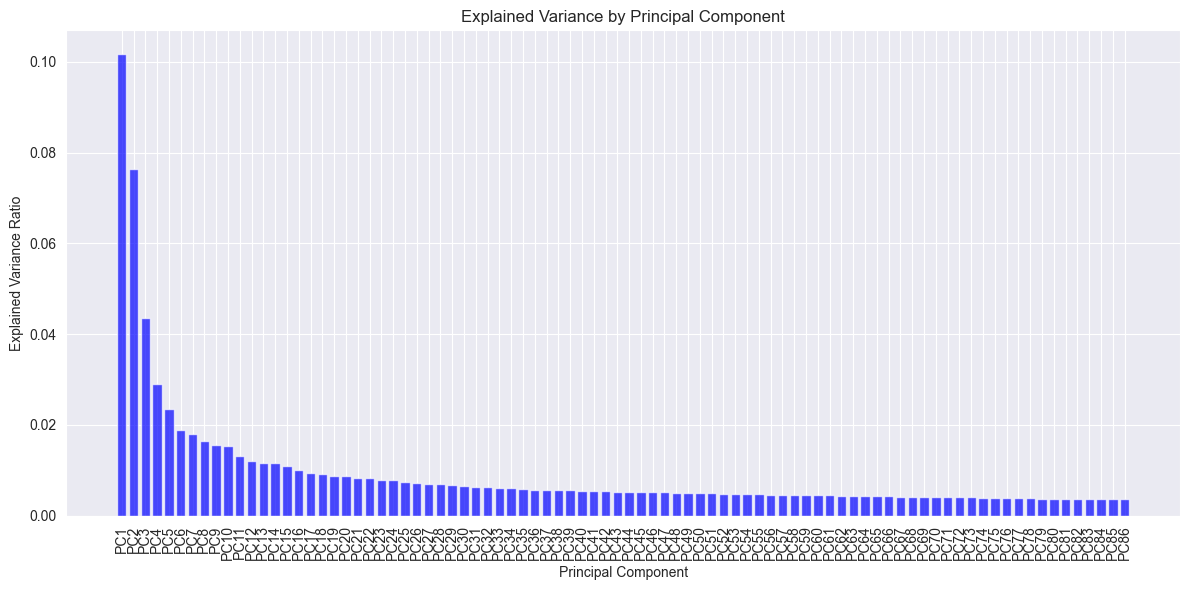

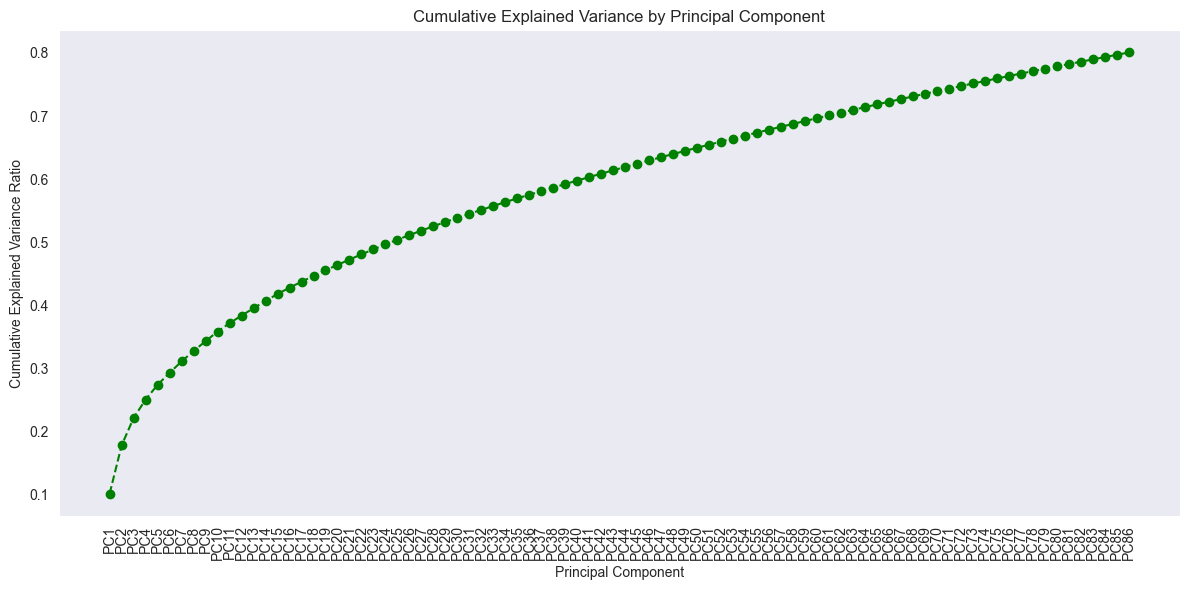

Explained Variance Ratios:
0     0.101804
1     0.076364
2     0.043592
3     0.029023
4     0.023481
        ...   
81    0.003702
82    0.003680
83    0.003660
84    0.003644
85    0.003601
Name: Explained Variance Ratio, Length: 86, dtype: float64


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the reduced PCA dataset and explained variance data
reduced_pca_df = pd.read_csv("nhanes_reduced_pca_dataset.csv", index_col=0)  # Replace with your file path
explained_variance = pd.read_csv("nhanes_pca_explained_variance.csv")  # Replace with your file path

# Extract the explained variance ratio for the reduced components
explained_variance_reduced = explained_variance.iloc[:len(reduced_pca_df.columns)]

# Plot the bar plot for explained variance ratio
plt.figure(figsize=(12, 6))
plt.bar(
    explained_variance_reduced["Principal Component"],
    explained_variance_reduced["Explained Variance Ratio"],
    color='blue',
    alpha=0.7
)
plt.title("Explained Variance by Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Calculate the cumulative explained variance
cumulative_variance = explained_variance_reduced["Explained Variance Ratio"].cumsum()

# Plot the cumulative explained variance as a line graph
plt.figure(figsize=(12, 6))
plt.plot(
    explained_variance_reduced["Principal Component"],
    cumulative_variance,
    marker='o',
    linestyle='--',
    color='green'
)
plt.title("Cumulative Explained Variance by Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()
plt.show()

# Inspect the explained variance ratio for debugging
print("Explained Variance Ratios:")
print(explained_variance_reduced["Explained Variance Ratio"])

Here the code is analyzing the results of PCA on a dataset. Explained variance and cumulative explained is being visualized. This is done to determine the optimal number of principal components needed to capture portion of the original data's variance. Dimensionality reduction and feature importance in the dataset is being addressed by the code.

The explained variance ratio for each principal component is shown by the bar plot. Here the X-axis represents the components and the Y-axis represents the proportion of variance explained. The decline in bar heights indicates that the first few components are capturing most of the dataset's variance by helping in dimensionality reduction.

### How many components will you use to fit a supervised learning model?

In [5]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Load and preprocess the dataset
data = pd.read_csv("nhanes_reduced_pca_dataset.csv")  # Replace with your dataset
numeric_data = data.select_dtypes(include=[np.number])  # Select numeric columns only
numeric_data = numeric_data.dropna()  # Drop missing values

# Step 2: Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Step 3: Apply PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Step 4: Extract explained variance
explained_variance = pd.DataFrame({
    "Principal Component": [f"PC{i+1}" for i in range(len(pca.explained_variance_ratio_))],
    "Explained Variance Ratio": pca.explained_variance_ratio_,
    "Cumulative Variance Ratio": np.cumsum(pca.explained_variance_ratio_)
})

# Step 5: Determine the number of components explaining 60% variance
n_components_60 = (explained_variance["Cumulative Variance Ratio"] < 0.60).sum() + 1

# Step 6: Reduce PCA results to selected components
reduced_pca_60_df = pd.DataFrame(
    pca_result[:, :n_components_60],  # Select the first 'n_components_60' components
    columns=[f"PC{i+1}" for i in range(n_components_60)],  # Label components as PC1, PC2, ...
    index=numeric_data.index  # Maintain the same index as the original data
)

# Step 7: Display results
print(f"Number of components for 60% cumulative variance: {n_components_60}")
print(f"Reduced PCA dataset shape: {reduced_pca_60_df.shape}")
print("Explained Variance for Selected Components:")
print(explained_variance.iloc[:n_components_60])

# Step 8: Save the reduced dataset for 60% cumulative variance to CSV (optional)
reduced_pca_60_df.to_csv("reduced_pca_60_dataset.csv", index=True)

Number of components for 60% cumulative variance: 52
Reduced PCA dataset shape: (2064, 52)
Explained Variance for Selected Components:
   Principal Component  Explained Variance Ratio  Cumulative Variance Ratio
0                  PC1                  0.013946                   0.013946
1                  PC2                  0.011494                   0.025440
2                  PC3                  0.011494                   0.036935
3                  PC4                  0.011494                   0.048429
4                  PC5                  0.011494                   0.059923
5                  PC6                  0.011494                   0.071417
6                  PC7                  0.011494                   0.082912
7                  PC8                  0.011494                   0.094406
8                  PC9                  0.011494                   0.105900
9                 PC10                  0.011494                   0.117394
10                PC11       

The code analyzes the results of a Principal Component Analysis (PCA) on a dataset. It visualizes the explained variance and cumulative explained variance to determine the optimal number of principal components needed to capture a significant portion of the original data's variance. This helps in understanding the dimensionality reduction and feature importance in the dataset.

There are  52 principal components. To retain 60% of the variance, 52 components were needed to reduce dimensionality. The first 5 components explain ~5.99% of the variance. Here PC1 alone contributes ~1.395%.

### 2D Scatterplot of the first two components

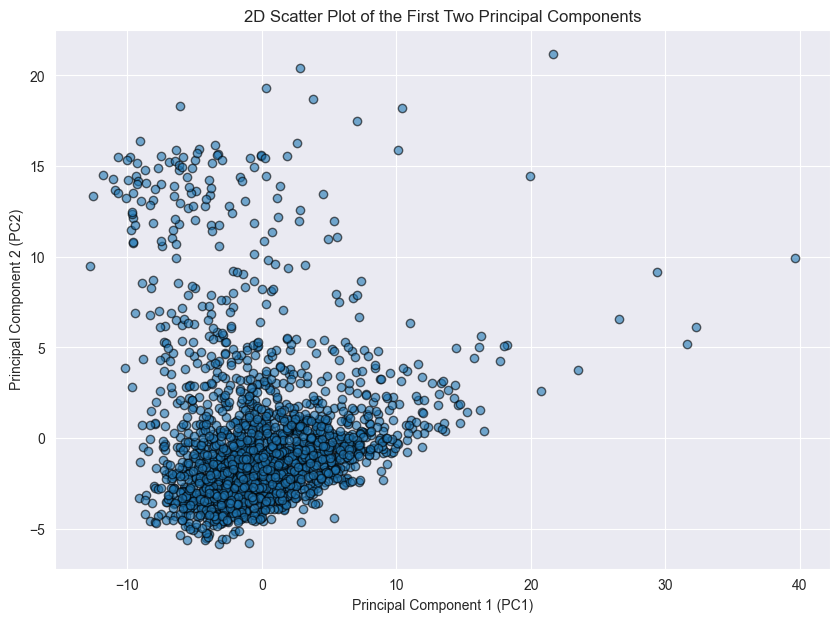

In [6]:
import matplotlib.pyplot as plt

# Create a scatter plot for the first two principal components
plt.figure(figsize=(10, 7))
plt.scatter(
    reduced_pca_df["PC1"],
    reduced_pca_df["PC2"],
    alpha=0.6,
    edgecolor='k'
)

# Add plot details
plt.title("2D Scatter Plot of the First Two Principal Components")
plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.grid(True)
plt.show()

2D scatter plot is being created to visualize the first two principal components obtained from a PCA analysis. The X-axis represents PC1 and the y-axis represents PC2. We can see the distribution and relationships between the first two principal components through this scatter plot.

The data points are distributed across the plot where the variation is being captured by these two components. Most clusters are near the origin whereas a few spread out. This indicates potential outliers.

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

We are choosing K-Means. Therefore we will use elbow method to find out number of clusters.

### Cluster nhanes

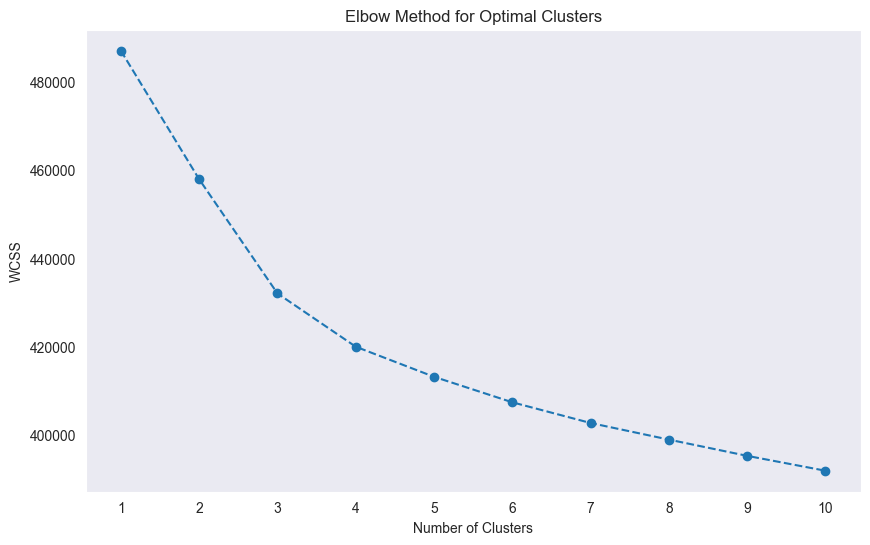

In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Load the raw NHANES dataset
nhanes = pd.read_csv("nhanes.csv")  # Replace with the correct file path

# Step 2: Separate the SEQN column
seqn = nhanes['SEQN']  # Keep SEQN as it is
data_to_scale = nhanes.drop(columns=['SEQN'])  # Drop SEQN for scaling

# Step 3: Scale the remaining data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_scale)
nhanes_scaled = pd.DataFrame(scaled_data, columns=data_to_scale.columns)

# Step 4: Add SEQN back to the scaled dataset
nhanes_scaled.insert(0, 'SEQN', seqn)  # Insert SEQN as the first column

# Save the corrected scaled dataset
nhanes_scaled.to_csv("nhanes_scaled_corrected.csv", index=False)

# Step 5: Proceed with K-means clustering
# Load the corrected scaled dataset
nhanes_scaled = pd.read_csv("nhanes_scaled_corrected.csv")

# Elbow Method to determine optimal number of clusters
wcss = []  # Within-Cluster-Sum-of-Squares
max_clusters = 10  # Check for up to 10 clusters

for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(nhanes_scaled.drop(columns=['SEQN']))  # Exclude SEQN for clustering
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, max_clusters + 1))
plt.grid()
plt.show()

# Step 6: Choose optimal number of clusters (e.g., 3) and fit KMeans
optimal_clusters = 3  # Adjust based on the Elbow Method
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(nhanes_scaled.drop(columns=['SEQN']))

# Add cluster labels to the dataset
nhanes_scaled_with_clusters = nhanes_scaled.copy()
nhanes_scaled_with_clusters['Cluster'] = cluster_labels

# Save the clustered dataset
nhanes_scaled_with_clusters.to_csv("nhanes_scaled_with_clusters_corrected.csv", index=False)

Making an elbow plot to find out the number of clusters.

The optimal number of clusters are 3 as we see curve near 3 and 4. We can choose either 3 or 4.

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

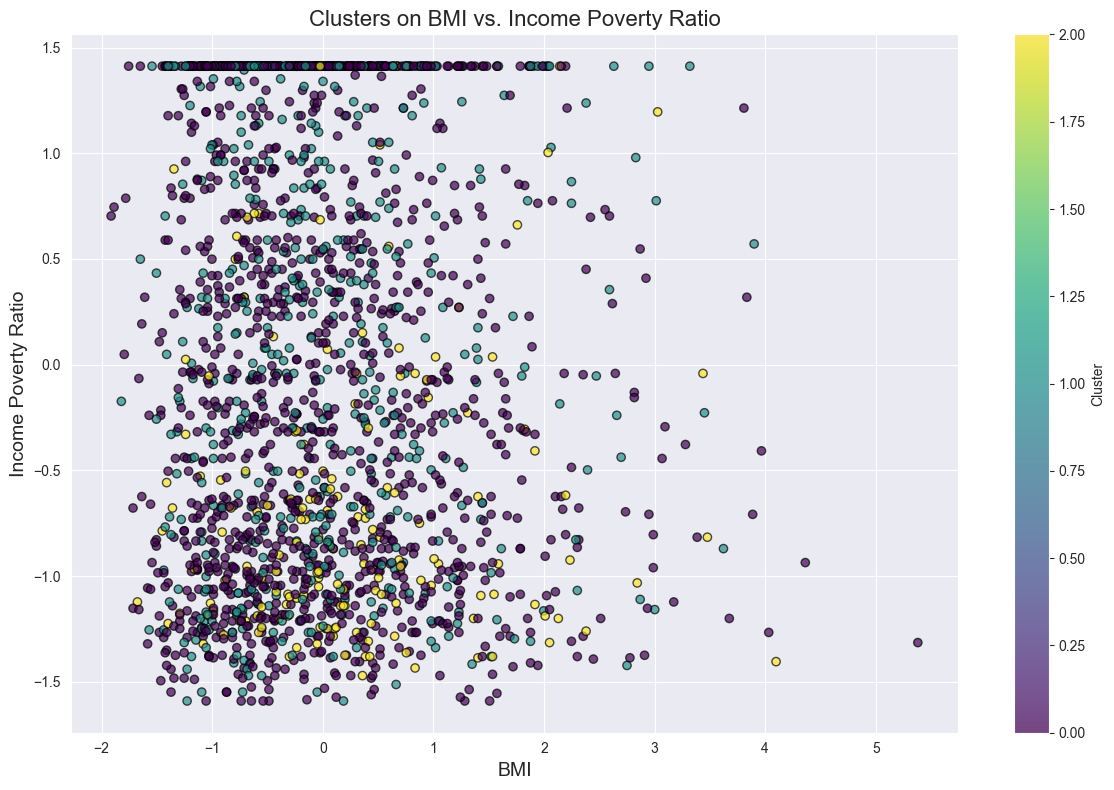

In [8]:
import matplotlib.pyplot as plt

# Ensure the relevant columns exist in the dataset
if 'BMXBMI' in nhanes_scaled_with_clusters.columns and 'INDFMPIR' in nhanes_scaled_with_clusters.columns:
    # Extract the relevant columns for plotting
    bmi = nhanes_scaled_with_clusters['BMXBMI']
    income_poverty_ratio = nhanes_scaled_with_clusters['INDFMPIR']
    clusters = nhanes_scaled_with_clusters['Cluster']

    # Create a scatter plot of BMI vs. Income Poverty Ratio colored by cluster
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(bmi, income_poverty_ratio, c=clusters, cmap='viridis', alpha=0.7, edgecolor='k')
    plt.colorbar(scatter, label='Cluster')
    plt.title('Clusters on BMI vs. Income Poverty Ratio', fontsize=16)
    plt.xlabel('BMI', fontsize=14)
    plt.ylabel('Income Poverty Ratio', fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("The required columns 'BMXBMI' and 'INDFMPIR' are not in the dataset.")

There is a scatter plot of BMI vs. Income Poverty Ratio which is color-coded by cluster assignments. Clusters are being displayed.

The BMI values range from approximately -2 to 5 and the Income Poverty Ratio is between -1.5 and 1.5. Clusters in the plot overlap with points of different colors appearing close together, indicating poor separability in this feature space. Some clusters might capture specific relationships between BMI and income poverty but the blurred boundaries suggest high variability.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

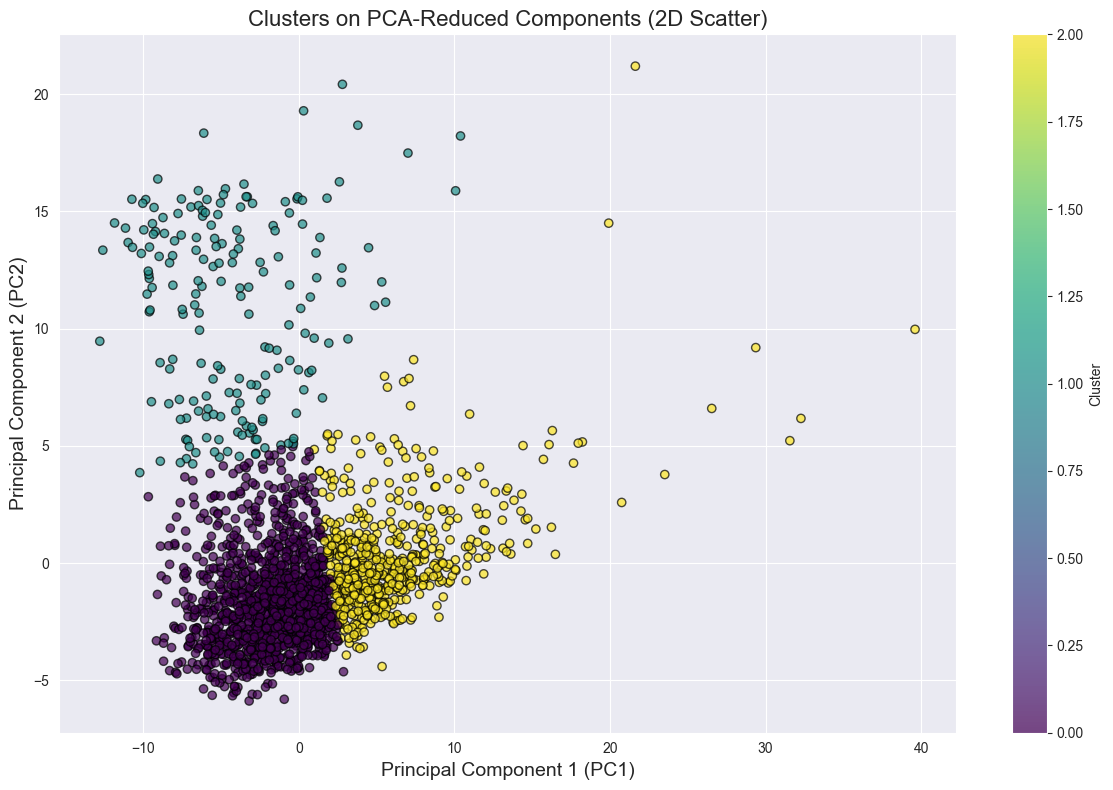

In [9]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Load the scaled NHANES dataset
nhanes_scaled = pd.read_csv("nhanes_scaled_corrected.csv")  # Replace with the correct file path

# Step 2: Perform PCA for dimensionality reduction to 2 components
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
nhanes_pca_result = pca.fit_transform(nhanes_scaled.drop(columns=['SEQN']))  # Exclude SEQN

# Create a DataFrame for the PCA-transformed data
nhanes_pca_df = pd.DataFrame(
    nhanes_pca_result,
    columns=['PC1', 'PC2']
)
nhanes_pca_df['SEQN'] = nhanes_scaled['SEQN']  # Reattach SEQN

# Step 3: Retrain K-means clustering on the PCA-reduced dataset
optimal_clusters = 3  # Adjust based on the Elbow Method
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(nhanes_pca_df[['PC1', 'PC2']])

# Add cluster labels to the PCA DataFrame
nhanes_pca_df['Cluster'] = cluster_labels

# Step 4: Plot the clusters on a 2D scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    nhanes_pca_df['PC1'],
    nhanes_pca_df['PC2'],
    c=nhanes_pca_df['Cluster'],
    cmap='viridis',
    alpha=0.7,
    edgecolor='k'
)
plt.colorbar(scatter, label='Cluster')
plt.title('Clusters on PCA-Reduced Components (2D Scatter)', fontsize=16)
plt.xlabel('Principal Component 1 (PC1)', fontsize=14)
plt.ylabel('Principal Component 2 (PC2)', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

PCA is used to reduce the dataset to two principal components for visualization.
K-means is used on the PCA-transformed data to group the data into clusters based on the optimal number of clusters. Here we are using 3 clusters.  The clusters are plotted in a 2D scatterplot using the two principal components in order to visualize the separation.


Scatter plot shows clusters formed using K-means after reducing the dataset to two principal components with PCA. There are three distinct clusters with groups of data points with similar characteristics in the PCA-transformed feature. The clear separation of clusters shows differentiation among the data points based on the selected components.

## Your Answer Here

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [10]:
# Create HSD010_binary based on HSD010
nhanes['HSD010_binary'] = nhanes['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']
)

# Encode binary target variable into 0 (poor) and 1 (good)
nhanes['HSD010_binary_encoded'] = nhanes['HSD010_binary'].map({'good': 1, 'poor': 0})

# Verify encoding
print(nhanes[['HSD010', 'HSD010_binary', 'HSD010_binary_encoded']].head())

# Step 4: Split data into features (X) and target (y)
X = nhanes.drop(columns=['HSD010', 'HSD010_binary', 'HSD010_binary_encoded', 'SEQN'], errors='ignore')
y = nhanes['HSD010_binary_encoded']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display sizes of the training and testing sets
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

   HSD010 HSD010_binary  HSD010_binary_encoded
0       1          good                      1
1       1          good                      1
2       2          good                      1
3       2          good                      1
4       3          good                      1
Training set size: 1651
Testing set size: 413


In [11]:
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import numpy as np

np.random.seed(42)

# Define model
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define checkpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Filename to save the best model
    monitor='val_accuracy',  # Metric to monitor
    mode='max',  # Save the model when val_accuracy is maximized
    save_best_only=True,  # Save only the best model
    verbose=1
)

# Train model with the checkpoint callback
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=10,
    verbose=1,
    callbacks=[checkpoint]
)

# Load the best model
best_model = load_model('best_model.keras')

# Evaluate the best model on the test data
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Best Model Test Loss: {loss}")
print(f"Best Model Test Accuracy: {accuracy}")

Epoch 1/100


C:\Users\chopr\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


156/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6602 - loss: 459.7454
Epoch 1: val_accuracy improved from -inf to 0.82809, saving model to best_model.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6684 - loss: 437.8857 - val_accuracy: 0.8281 - val_loss: 0.7271
Epoch 2/100
154/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8423 - loss: 1.1503
Epoch 2: val_accuracy did not improve from 0.82809
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8423 - loss: 1.3638 - val_accuracy: 0.8281 - val_loss: 0.6144
Epoch 3/100
141/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8352 - loss: 1.0173
Epoch 3: val_accuracy did not improve from 0.82809
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8359 - loss: 1.0393 - val_accuracy: 0.8281 - val_loss: 0.5802
Epoch 4/100
147/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8335 - loss: 0.6020
Epoch 4: val_accuracy did not improve from 0.82809
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8343 - loss: 0.

Accuracy on the test data with original features is 82.8%

### Neural Network on Principal Components

In [41]:
X = pd.read_csv("nhanes_reduced_pca_dataset.csv")
X.drop(columns=['SEQN'], inplace=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display sizes of the training and testing sets
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 1651
Testing set size: 413


In [45]:
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import numpy as np

np.random.seed(42)

# Define model
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define checkpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Filename to save the best model
    monitor='val_accuracy',  # Metric to monitor
    mode='max',  # Save the model when val_accuracy is maximized
    save_best_only=True,  # Save only the best model
    verbose=1
)

# Train model with the checkpoint callback
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=10,
    verbose=1,
    callbacks=[checkpoint]
)

# Load the best model
best_model = load_model('best_model.keras')

# Evaluate the best model on the test data
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Best Model Test Loss: {loss}")
print(f"Best Model Test Accuracy: {accuracy}")


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


152/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5490 - loss: 0.7153
Epoch 1: val_accuracy improved from -inf to 0.81356, saving model to best_model.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5615 - loss: 0.7049 - val_accuracy: 0.8136 - val_loss: 0.4760
Epoch 2/100
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8199 - loss: 0.4509
Epoch 2: val_accuracy improved from 0.81356 to 0.84019, saving model to best_model.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8208 - loss: 0.4491 - val_accuracy: 0.8402 - val_loss: 0.4251
Epoch 3/100
130/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8573 - loss: 0.3560
Epoch 3: val_accuracy improved from 0.84019 to 0.85714, saving model to best_model.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8583 - loss: 0.3521 - val_accuracy: 0.8571 - val_loss: 0.4061
Epoch 4/100
151/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8858 - loss: 0.2998
Epoch 4: val_accuracy did not improve from 0.8571

Accuracy on the test data with PCA is 85.7%

### Neural Network on Principal Components + Cluster Membership

In [17]:
X = pd.read_csv("nhanes_scaled_with_clusters_corrected.csv")
X.drop(columns=['SEQN'], inplace=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display sizes of the training and testing sets
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 1651
Testing set size: 413


In [18]:
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import numpy as np

np.random.seed(42)

# Define model
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define checkpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Filename to save the best model
    monitor='val_accuracy',  # Metric to monitor
    mode='max',  # Save the model when val_accuracy is maximized
    save_best_only=True,  # Save only the best model
    verbose=1
)

# Train model with the checkpoint callback
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=10,
    verbose=1,
    callbacks=[checkpoint]
)

# Load the best model
best_model = load_model('best_model.keras')

# Evaluate the best model on the test data
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Best Model Test Loss: {loss}")
print(f"Best Model Test Accuracy: {accuracy}")


Epoch 1/100


C:\Users\chopr\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


146/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5069 - loss: 0.8240
Epoch 1: val_accuracy improved from -inf to 0.86199, saving model to best_model.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5307 - loss: 0.7956 - val_accuracy: 0.8620 - val_loss: 0.3689
Epoch 2/100
141/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8726 - loss: 0.3196
Epoch 2: val_accuracy improved from 0.86199 to 0.86441, saving model to best_model.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8741 - loss: 0.3162 - val_accuracy: 0.8644 - val_loss: 0.3214
Epoch 3/100
144/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9077 - loss: 0.2437
Epoch 3: val_accuracy improved from 0.86441 to 0.87893, saving model to best_model.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9081 - loss: 0.2417 - val_accuracy: 0.8789 - val_loss: 0.2774
Epoch 4/100
131/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9274 - loss: 0.1797
Epoch 4: val_accuracy improved from 0.87893 to 0.

Both the algorithm methods did really well. I would choose. I will choose PCA plus cluster membership as its accuracy is really high.

Accuracy on the test data with PCA is 95.3%

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

PCA - Reduces dimensionality by keeping the variance. It is variance-based not grouping-based. Its outputs are continuous variables. It looks for patterns in data.

Clustering - It groups similar data. It is unsupervised. Its outputs are distant metrics. The output is different cluster labels.

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

Yes, combining PCA and clustering has advantages. PCA reduces dimensionality, eliminates noise and redundancy which helps in simplifying the clustering process and making it more effective. By adding cluster membership as a feature to PCA-transformed data we see that the model gains additional structural information which leads to higher accuracy. In this case 95.3%. 

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

- Dimension reduction takes place
- Look in the data to find meaningful features
- Identifies outliers
- Boost supervised model performance
- Grouping of data without labels into similar subsets
- Handles irrelevant features
- Better accuracy of neural networks